In [41]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import stats
import math

## Functions

### Configuration model

In [11]:
def non_multi_config_model(G): 
    
    '''Version of config model which does not generate non simple graphs if the 
    orignal graph is a simple graph, works for directed networks also'''     

    edge_list = list(G.edges())        
    num_trials = G.number_of_edges()

    for _ in range(num_trials):
        if len(edge_list)<2:
            break

        #Choosing edges from orignal network at random
        edge1=random.choice(edge_list) 
        edge2=random.choice(edge_list)
        if edge1==edge2:
            continue

        a,b=edge1
        c,d=edge2

        new_edges = [(a,d),(c,b)]

        #Step Avoiding Multi-Edges and Self loops from occuring in randomised network
        if a==d or c==b:
            continue

        if G.has_edge(*new_edges[0]) or G.has_edge(*new_edges[1]): 
            continue

        #Swapping the stubs
        G.remove_edges_from([edge1, edge2])
        G.add_edges_from(new_edges)

        edge_list.remove(edge1)
        edge_list.remove(edge2)

    return G

### Measures

In [12]:
def power_method(A, v_0, sensitivity=1e-6, max_iter=1000):

    '''Function for finding the dominant eigen value (if it exits) for a matrix and also the
    corresponding eigen vector'''

    A = np.array(A, dtype=float)
    v_0 = np.array(v_0, dtype=float)
    v_0 = v_0 / np.linalg.norm(v_0)
    old_vector = v_0
    residuals = []
    iterations = 0

    while iterations < max_iter:
        iterations += 1
        new_vector = A @ old_vector
        scale = np.max(np.abs(new_vector))
        if scale == 0:
            raise ValueError("No dominant eigen value")
        new_vector = new_vector / scale  #Scaling to prevent overflow
        residual = np.linalg.norm(A @ new_vector - scale * new_vector)
        residuals.append(residual)

        if residual<sensitivity:
            break

        old_vector = new_vector

    lambda_1 = new_vector.T @ A @ new_vector / (new_vector.T @ new_vector)
    new_vector = new_vector / np.linalg.norm(new_vector)

    return lambda_1, new_vector


def katz_centralities(G,alpha,sensitivity=1e-6):

    '''For computing the Katz centrality according the definition given in Newman (book),
    networkx library follows a different definition so results from this function and the networkx built in do not match'''
    
    A=nx.to_numpy_array(G)
    Beta=1
    centralities=np.ones(len(A))

    while True:
        old_centralities=centralities.copy()
        centralities=alpha*(A@centralities)+Beta
        centralities/=np.linalg.norm(centralities) #Normalising to prevent overflow

        if np.all(abs(old_centralities-centralities)<1e-6):
            break

    centralities/=np.linalg.norm(centralities)

    return centralities

def page_rank(G,beta=1.0):

    '''For computing the Page rank centrality according the definition given in Newman (book),
    networkx library follows a different definition so results from this function and the networkx built in do not match'''

    A = nx.to_numpy_array(G)
    degrees=np.zeros(len(A))

    for n,d in G.out_degree():
        if d>0:
            degrees[int(n)-1]=d
        else:
            degrees[int(n)-1]=1

    D_inv = np.diag(1/degrees)

    v_0=np.zeros(len(A))
    v_0[0]=1

    # eigenvalue,vec=power_method(A@D_inv,v_0)
    # alpha=random.uniform(0,1/eigenvalue) (Protein matrix AD-1 does not have a dominant eigen vector)

    alpha=0.85

    centralities=np.ones(len(A))
    
    while True:
        old_centralities=centralities.copy()
        centralities=alpha*(A@D_inv@centralities)+beta
        centralities/=np.linalg.norm(centralities)

        if np.all(abs(old_centralities-centralities)<1e-6):
            break

    centralities/=np.linalg.norm(centralities)

    return centralities,alpha

def modularity(G, communities):

    '''For undirected graphs'''

    Q = 0
    m = G.number_of_edges()
    
    for community in communities:
        subgraph = G.subgraph(community)
        L_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(L_c/m)-(k_c/(2*m))**2

    return Q

def assortivity_coeff(G,communities):

    '''For undirected graphs'''

    Q = 0
    m = G.number_of_edges()
    Q_max=1
    
    for community in communities:
        subgraph = G.subgraph(community)
        L_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(L_c/m)-(k_c/(2*m))**2
        Q_max-=(k_c/(2*m))**2
         
    return Q/Q_max

def top_k_nodes(centrality_vals, k=3, centrality_name="",reverse=True):
    if isinstance(centrality_vals, dict):
        items = list(centrality_vals.items())  
    else:
        node_ids = list(G.nodes())
        items = list(zip(node_ids, centrality_vals))

    # Sort and print
    top_nodes = sorted(items, key=lambda x: x[1], reverse=reverse)[:k]
    print(f"\nTop {k} nodes by {centrality_name}:")

    for node_id, value in top_nodes:
        name = Node_meta.get(node_id, f"Node {node_id}")  #Node_meta is the file containing the node names corresponding to the integer ids
        print(f"  {name} (ID {node_id}) — {centrality_name}: {value:.4f}")

### Jensen-Shanon Functions

In [13]:
def entropy(p):
    p=np.array(p, dtype=np.float64)
    p=p[p>0] #Taking the value of -0*log(0) as 0 (Tends to 0 anyway)
    return np.sum(p * np.log2(1 / p))

def Jensen_Shannon(p,q): 
    
    '''Function for calculating the jensen-shanon difference, not divergence'''

    p=np.array(p, dtype=np.float64)
    q=np.array(q, dtype=np.float64)
    
    p/=p.sum()  
    q/=q.sum()
    
    mixture=0.5*(p+q)
    JSD=entropy(mixture)-0.5*(entropy(p)+entropy(q))
    return np.sqrt(JSD)

def obtain_distribution(array, box_size, number, range_vals):
    distribution, bin_edges = np.histogram(array, bins=number, range=range_vals)
    distribution = distribution / distribution.sum() 
    return distribution, bin_edges

import numpy as np

def obtain_log_distribution(array, number, range_vals):
    """Compute a log-binned distribution of an array and return bin edges."""

    number=40

    bins = np.logspace(np.log10(range_vals[0]), np.log10(range_vals[1]), number)
    bins = np.logspace(np.log10(range_vals[0]), np.log10(range_vals[1]), number+1)
    distribution, edges = np.histogram(array, bins=bins)
    # Normalizing
    distribution = distribution / distribution.sum()

    return distribution, edges


def Jensen_Shanon_for_arrays(array1, array2, number_bins=30,log_bins=False):

    # Determine bin size using Freedman-Diaconis rule
    IQR = max(stats.iqr(array1), stats.iqr(array2))
    n = min(len(array1), len(array2))
    bin_width = 2 * IQR / n**(1/3)

    if bin_width == 0:  # avoid divide by zero again
        bin_width = 1e-5  # arbitrary small bin width

    # Get the total number of bins
    min_val = min(np.min(array1), np.min(array2))
    if min_val <= 0:
        min_val = 1e-10  # fallback
    max_val = max(np.max(array1), np.max(array2))
    number_bins = int(np.ceil((max_val - min_val) / bin_width))
    range_vals = (min_val, min_val + number_bins * bin_width)

    if log_bins==True:
        dist1,edges1= obtain_log_distribution(array1,number_bins,range_vals)
        dist2,edges2= obtain_log_distribution(array2,number_bins,range_vals)
    
    else:
        dist1,edges1 = obtain_distribution(array1, bin_width, number_bins, range_vals)
        dist2,edges2 = obtain_distribution(array2, bin_width, number_bins, range_vals)

    return Jensen_Shannon(dist1, dist2),dist2,edges2


### Misc

In [14]:
def R_squared(y_obs,y_expected):

    '''Calculates coefficient of determination'''
    
    y_obs=np.array(y_obs)
    y_expected=np.array(y_expected)
    y_obs_mean=np.mean(y_obs)

    SS_residual=np.sum((y_obs-y_expected)**2)
    SS_total=np.sum((y_obs-y_obs_mean)**2)

    return 1-(SS_residual/SS_total)

## Loading Graph

In [15]:
# Load the graph
G = nx.read_gml("power.gml", label=None)
num_components = nx.number_connected_components(G)
print("Number of edges:", G.number_of_edges())
print("Number of nodes:",nx.number_of_nodes(G))
print("Number of connected components:", num_components)

Number of edges: 6594
Number of nodes: 4941
Number of connected components: 1


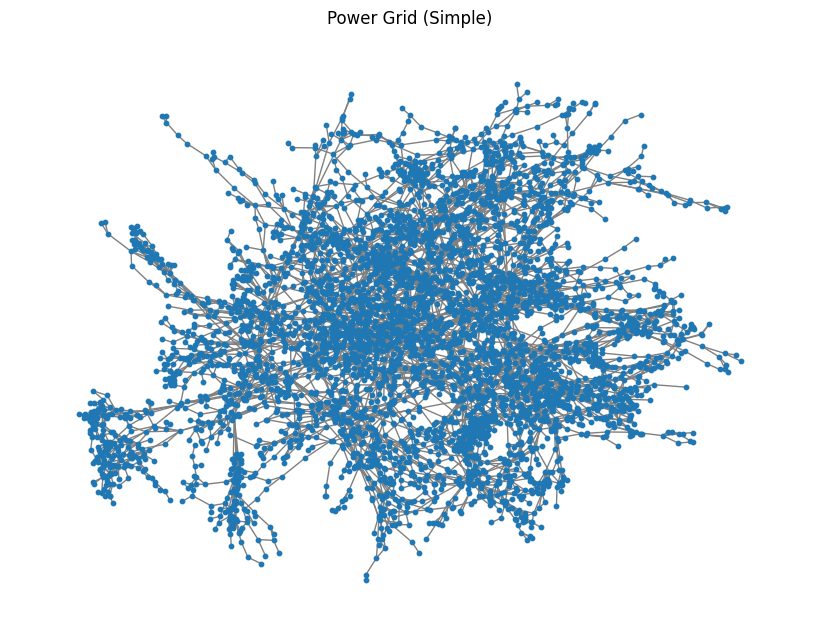

In [16]:
pos=nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos,
        node_size=10,
        edge_color='gray')
plt.title("Power Grid (Simple)")
plt.show()

## Centrality Analysis

Number of edges: 6594


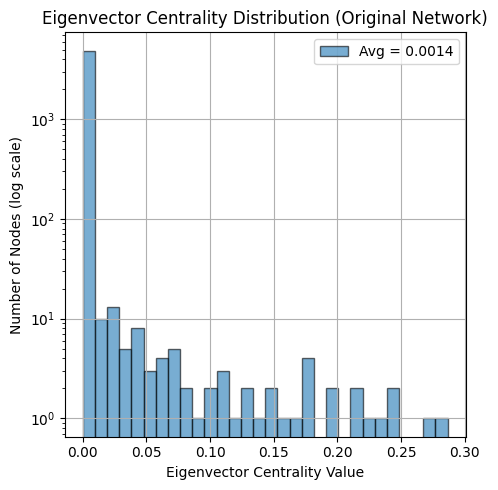

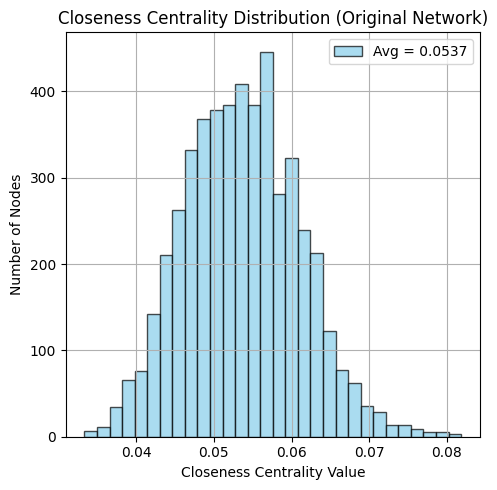

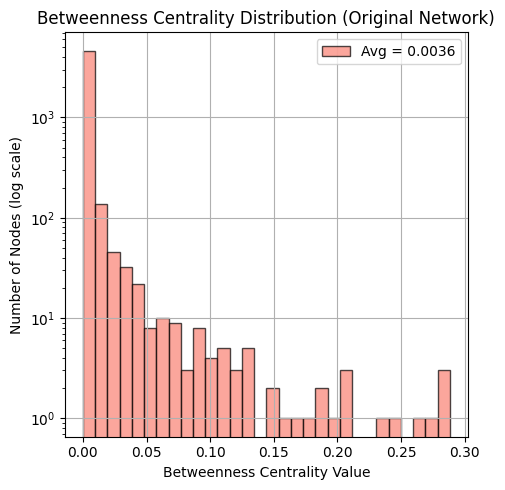

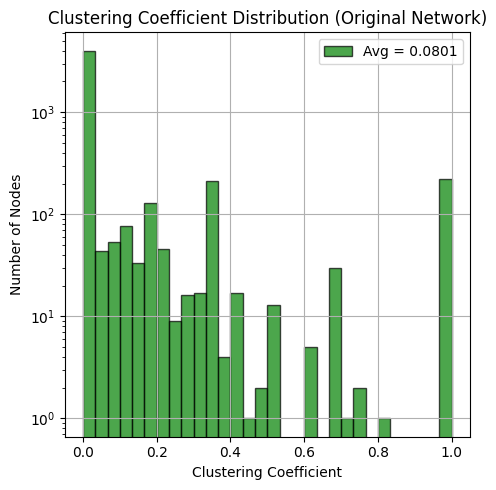

Original Graph Centrality Averages:
  Eigenvector     : 0.0014
  Closeness       : 0.0537
  Betweenness     : 0.0036
  Clustering Coeff: 0.0801
Number of connected components: 1


In [17]:
ki = np.array([d for n, d in G.degree()])
n = len(ki)
print("Number of edges:", G.number_of_edges())

# Use consistent settings
figsize = (5, 5)
dpi = 100

# --- Eigenvector Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
og_eigenvector_vals = list(nx.eigenvector_centrality_numpy(G).values())
avg_eigen = np.mean(og_eigenvector_vals)
plt.hist(og_eigenvector_vals, bins=30, alpha=0.6, label=f'Avg = {avg_eigen:.4f}', edgecolor='black')
plt.title("Eigenvector Centrality Distribution (Original Network)")
plt.xlabel("Eigenvector Centrality Value")
plt.ylabel("Number of Nodes (log scale)")
plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("eigenvector_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Closeness Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
og_closeness_vals = list(nx.closeness_centrality(G).values())
avg_closeness = np.mean(og_closeness_vals)
plt.hist(og_closeness_vals, bins=30, alpha=0.7, color='skyblue', label=f'Avg = {avg_closeness:.4f}', edgecolor='black')
plt.title("Closeness Centrality Distribution (Original Network)")
plt.xlabel("Closeness Centrality Value")
plt.ylabel("Number of Nodes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("closeness_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Betweenness Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
og_betweenness_vals = list(nx.betweenness_centrality(G).values())
avg_betweenness = np.mean(og_betweenness_vals)
plt.hist(og_betweenness_vals, bins=30, alpha=0.7, color='salmon', label=f'Avg = {avg_betweenness:.4f}', edgecolor='black')
plt.title("Betweenness Centrality Distribution (Original Network)")
plt.xlabel("Betweenness Centrality Value")
plt.ylabel("Number of Nodes (log scale)")
plt.yscale('log')  # heavy-tailed distribution
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("betweenness_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Clustering Coefficient ---
plt.figure(figsize=figsize, dpi=dpi)
og_clustering_vals = list(nx.clustering(G).values())
avg_clustering = np.mean(og_clustering_vals)
plt.hist(og_clustering_vals, bins=30, alpha=0.7, color='green', label=f'Avg = {avg_clustering:.4f}', edgecolor='black')
plt.title("Clustering Coefficient Distribution (Original Network)")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Number of Nodes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.yscale('log')
plt.savefig("clustering_coefficient_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# Print average values to console
print("Original Graph Centrality Averages:")
print(f"  Eigenvector     : {avg_eigen:.4f}")
print(f"  Closeness       : {avg_closeness:.4f}")
print(f"  Betweenness     : {avg_betweenness:.4f}")
print(f"  Clustering Coeff: {avg_clustering:.4f}")

num_components = nx.number_connected_components(G)
print("Number of connected components:", num_components)

 90%|█████████ | 18/20 [21:02<02:32, 76.34s/it]C:\Users\Tvisha\AppData\Local\Temp\ipykernel_12332\2100401259.py:22: RuntimeWarning: invalid value encountered in divide
  distribution = distribution / distribution.sum()
C:\Users\Tvisha\AppData\Local\Temp\ipykernel_12332\2100401259.py:18: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(JSD)
100%|██████████| 20/20 [23:48<00:00, 71.42s/it]


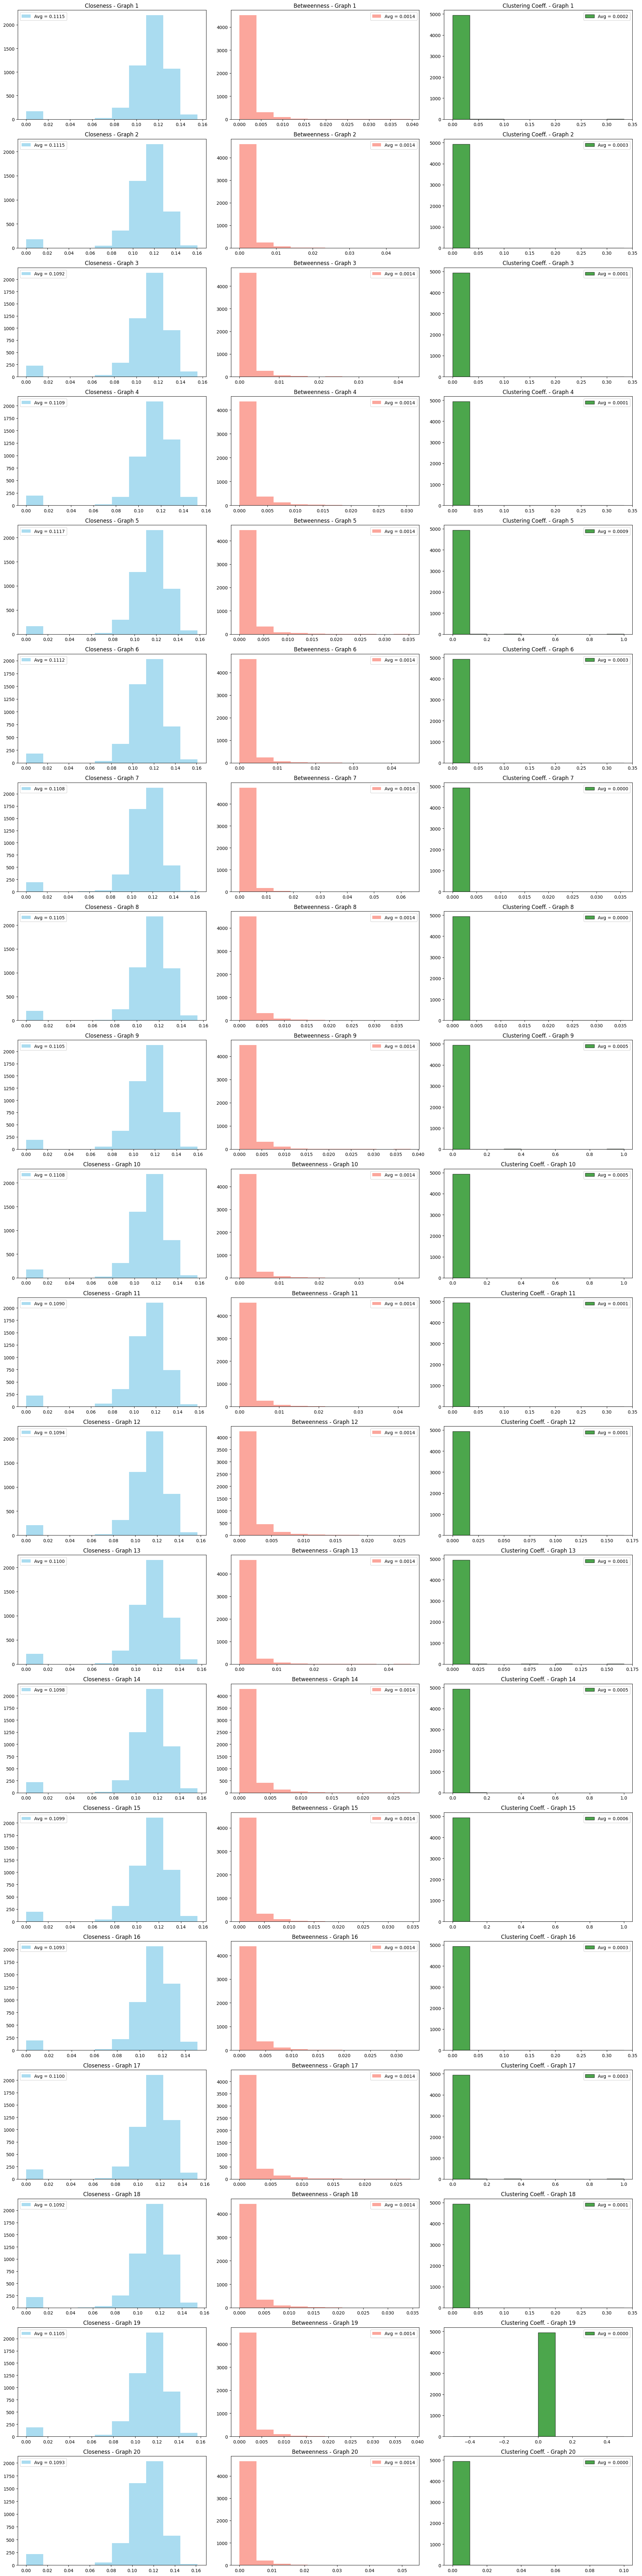

In [19]:
noofgraphs = 20
n = len(G.nodes)
v_0 = np.zeros(n)
v_0[0] = 1

summary = []
avg_closeness_overall=np.zeros(len(G.nodes))
avg_betweenness_overall=np.zeros(len(G.nodes))
avg_clustering_overall=np.zeros(len(G.nodes))

fig, axes = plt.subplots(noofgraphs, 3, figsize=(20, 4 * noofgraphs)) 

'''Eigen-vector centrality has not been computed as the random graphs produced have more than one component'''

for i in tqdm(range(noofgraphs), total=noofgraphs):
    D = non_multi_config_model(G)

    # 1. Closeness Centrality
    closeness_vals = np.array(list(nx.closeness_centrality(D).values()))
    avg_closeness = np.mean(closeness_vals)
    axes[i][0].hist(closeness_vals, alpha=0.7, color='skyblue', label=f'Avg = {avg_closeness:.4f}')
    axes[i][0].set_title(f"Closeness - Graph {i+1}")
    axes[i][0].legend()
    avg_closeness_overall+=closeness_vals/noofgraphs

    array1=og_closeness_vals
    array2=closeness_vals
    js_closeness = Jensen_Shanon_for_arrays(array1,array2)
    ks_closeness=stats.ks_2samp(array1,array2)

    # 2. Betweenness Centrality
    betweenness_vals = np.array(list(nx.betweenness_centrality(D).values()))
    avg_betweenness = np.mean(betweenness_vals)
    axes[i][1].hist(betweenness_vals, alpha=0.7, color='salmon', label=f'Avg = {avg_betweenness:.4f}')
    axes[i][1].set_title(f"Betweenness - Graph {i+1}")
    axes[i][1].legend()
    avg_betweenness_overall+=betweenness_vals/noofgraphs

    array1=og_betweenness_vals
    array2= betweenness_vals
    js_betweenness = Jensen_Shanon_for_arrays(array1,array2)
    ks_betweenness = stats.ks_2samp(array1,array2)

    # 3. Clustering Coefficient
    clustering_vals = np.array(list(nx.clustering(D).values()))
    avg_clustering = np.mean(clustering_vals)
    axes[i][2].hist(clustering_vals, alpha=0.7, color='green', edgecolor='black', label=f'Avg = {avg_clustering:.4f}')
    axes[i][2].set_title(f"Clustering Coeff. - Graph {i+1}")
    axes[i][2].legend()
    avg_clustering_overall+=clustering_vals/noofgraphs

    array1=og_clustering_vals
    array2= clustering_vals
    js_clustering = Jensen_Shanon_for_arrays(array1,array2)
    ks_clustering = stats.ks_2samp(array1,array2)

    # Store in summary
    summary.append({
        "Closeness Avg": avg_closeness,
        "JS Closeness": js_closeness,
        "KS Closeness": ks_closeness,
        "Betweenness Avg": avg_betweenness,
        "JS Betweenness": js_betweenness,
        "KS Betweenness": ks_betweenness,
        "Clustering Avg": avg_clustering,
        "JS Clustering": js_clustering,
        "KS Clustering": ks_clustering,
    })

plt.tight_layout()
plt.show()


In [20]:
num_components = nx.number_connected_components(G)
print("Number of connected components for last random:",num_components)

Number of connected components for last random: 95


### Summary Table

In [21]:
# Creating summary table
summary_df = pd.DataFrame(summary)
summary_df = summary_df.round(4).to_string(index=False)

print("\nSummary of Centrality Averages and Jensen-Shannon Distances:\n")
print(summary_df)


Summary of Centrality Averages and Jensen-Shannon Distances:

 Closeness Avg                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [43]:
avg=0
for i in summary:
    if not(math.isnan(i["JS Clustering"][0])):
        avg+=i["JS Clustering"][0]/19

print(avg)

0.7281633076556263


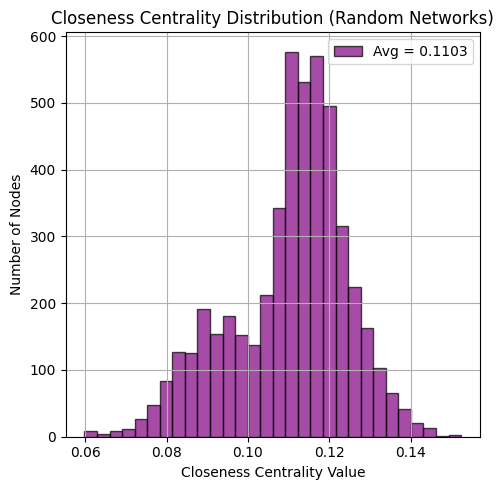

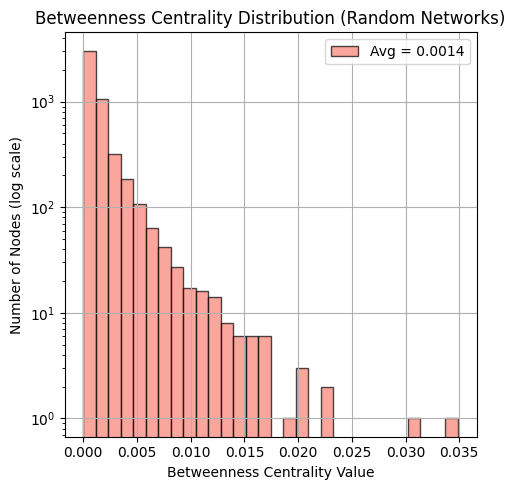

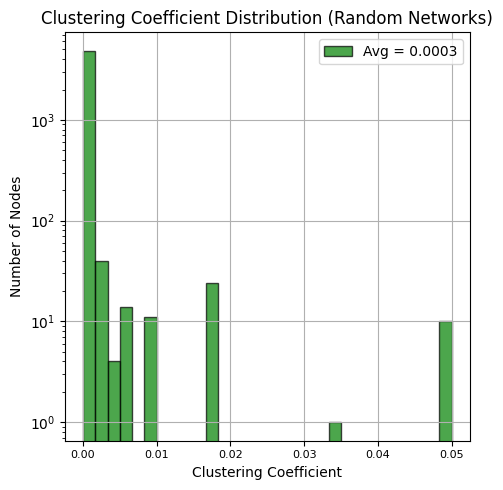

Original Graph Centrality Averages:
  Closeness       : 0.1103
  Betweenness     : 0.0014
  Clustering Coeff: 0.0003


'Averages for Eigen vector, Page Rank and Katz have no physical significance'

In [26]:
# Use consistent settings
figsize = (5, 5)
dpi = 100

# --- Closeness Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
avg_closeness = np.mean(avg_closeness_overall)
plt.hist(avg_closeness_overall, bins=30, alpha=0.7, color='purple',
         label=f'Avg = {avg_closeness:.4f}', edgecolor='black')
plt.title("Closeness Centrality Distribution (Random Networks)")
plt.xlabel("Closeness Centrality Value")
plt.ylabel("Number of Nodes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("closeness_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Betweenness Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
avg_betweenness = np.mean(avg_betweenness_overall)
plt.hist(avg_betweenness_overall, bins=30, alpha=0.7, color='salmon',
         label=f'Avg = {avg_betweenness:.4f}', edgecolor='black')
plt.title("Betweenness Centrality Distribution (Random Networks)")
plt.xlabel("Betweenness Centrality Value")
plt.ylabel("Number of Nodes (log scale)")
plt.yscale('log')  # heavy-tailed distribution
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("betweenness_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Clustering Coefficient ---
plt.figure(figsize=figsize, dpi=dpi)
avg_clustering = np.mean(avg_clustering_overall)
plt.hist(avg_clustering_overall, bins=30, alpha=0.7, color='green',
         label=f'Avg = {avg_clustering:.4f}', edgecolor='black')
plt.title("Clustering Coefficient Distribution (Random Networks)")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Number of Nodes")
plt.xticks(fontsize=8)
plt.legend()
plt.grid()
plt.tight_layout()
plt.yscale('log')
plt.savefig("clustering_coefficient_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# Print average values to console
print("Original Graph Centrality Averages:")
# print(f"  Eigenvector     : {avg_eigen:.4f}")
print(f"  Closeness       : {avg_closeness:.4f}")
print(f"  Betweenness     : {avg_betweenness:.4f}")
print(f"  Clustering Coeff: {avg_clustering:.4f}")
'''Averages for Eigen vector, Page Rank and Katz have no physical significance'''

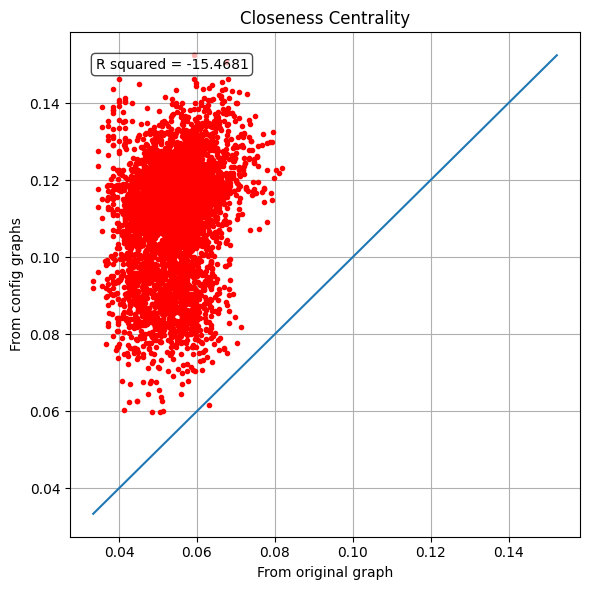

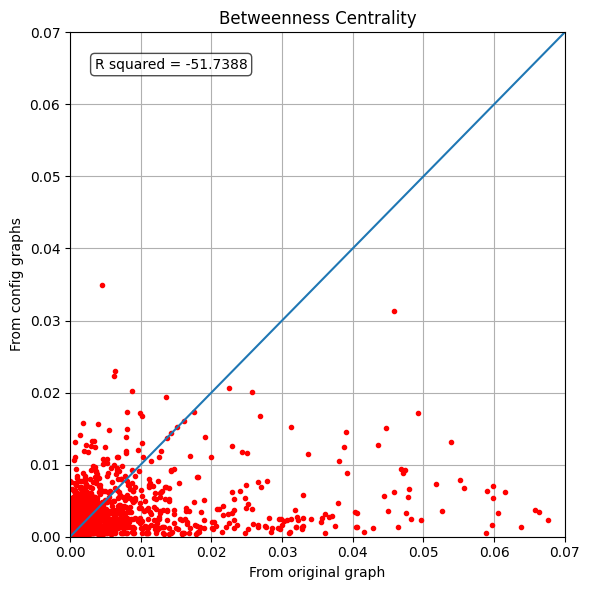

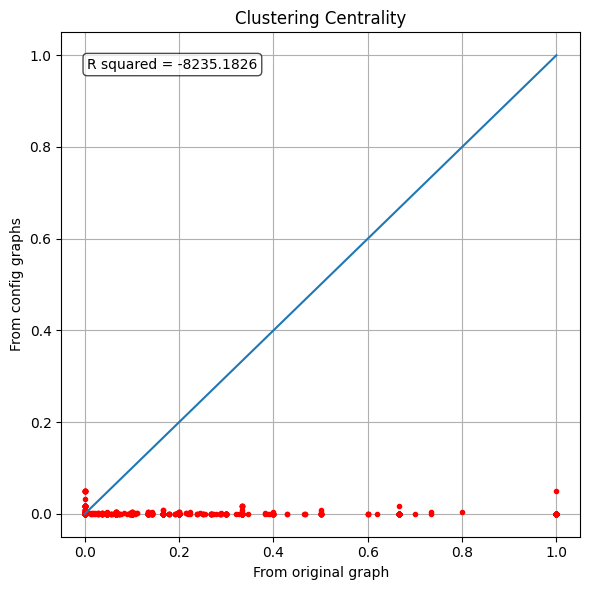

In [37]:
def plot_comparison(array1, array2, title, xlabel, ylabel, filename, xlim=None, ylim=None):
    plt.figure(figsize=(6,6))
    coords = np.column_stack((array1, array2))
    
    plt.plot(coords[:,0], coords[:,1], "ro", markersize=3)
    minim = min(min(coords[:,0]), min(coords[:,1]))
    maxim = max(max(coords[:,0]), max(coords[:,1]))
    plt.plot([minim, maxim], [minim, maxim])

    Rsquaredval = R_squared(array2, array1)
    plt.text(0.05, 0.95, f'R squared = {Rsquaredval:.4f}',
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)   # save each individually
    plt.show()


# Now call for each case

plot_comparison(og_closeness_vals, avg_closeness_overall,
                "Closeness Centrality", "From original graph", "From config graphs",
                "closeness_nodes.png")

plot_comparison(og_betweenness_vals, avg_betweenness_overall,
                "Betweenness Centrality", "From original graph", "From config graphs",
                "betweenness_nodes.png",
                xlim=(0,0.07), ylim=(0,0.07))

plot_comparison(og_clustering_vals, avg_clustering_overall,
                "Clustering Centrality", "From original graph", "From config graphs",
                "clustering_nodes.png")